In [1]:
import sys
refer_path = "D:\\Datasets\\refer-master\\refer-master" #path to the refer-master folder
img_path = refer_path+"\\data\\images\\mscoco\\images\\train2014\\" #path to images
sys.path.append(refer_path)
from refer import REFER
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pprint import pprint
import csv
import cv2
# IoU function
def computeIoU(box1, box2):
    # each box is of [x1, y1, w, h]
    inter_x1 = max(box1[0], box2[0])
    inter_y1 = max(box1[1], box2[1])
    inter_x2 = min(box1[0]+box1[2]-1, box2[0]+box2[2]-1)
    inter_y2 = min(box1[1]+box1[3]-1, box2[1]+box2[3]-1)

    if inter_x1 < inter_x2 and inter_y1 < inter_y2:
        inter = (inter_x2-inter_x1+1)*(inter_y2-inter_y1+1)
    else:
        inter = 0
    union = box1[2]*box1[3] + box2[2]*box2[3] - inter
    return float(inter)/union
    
    
data_root = refer_path + '/data'  # contains refclef, refcoco, refcoco+, refcocog and images
dataset = 'refcoco+'
splitBy = 'unc'
refer = REFER(data_root, dataset, splitBy)


ref_ids = refer.getRefIds()
print(len(ref_ids))
print (len(refer.Imgs))
print (len(refer.imgToRefs))

ref_ids = refer.getRefIds(split='train')
print ('There are %s training referred objects.' % len(ref_ids))

#initialize LSeg
import os
import argparse
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch.utils import data
import torchvision.transforms as transform
from torch.nn.parallel.scatter_gather import gather

import encoding.utils as utils
from encoding.nn import SegmentationLosses, SyncBatchNorm
from encoding.parallel import DataParallelModel, DataParallelCriterion
from encoding.datasets import test_batchify_fn 
from encoding.models.sseg import BaseNet
from additional_utils.models import LSeg_MultiEvalModule
from modules.lseg_module import LSegModule

import math
import types
import functools
import torchvision.transforms as torch_transforms
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import clip
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg
from data import get_dataset
import torchvision.transforms as transforms

class Options:
    def __init__(self):
        parser = argparse.ArgumentParser(description="PyTorch Segmentation")
        # model and dataset
        parser.add_argument(
            "--model", type=str, default="encnet", help="model name (default: encnet)"
        )
        parser.add_argument(
            "--backbone",
            type=str,
            default="clip_vitl16_384",
            help="backbone name (default: resnet50)",
        )
        parser.add_argument(
            "--dataset",
            type=str,
            default="ade20k",
            help="dataset name (default: pascal12)",
        )
        parser.add_argument(
            "--workers", type=int, default=16, metavar="N", help="dataloader threads"
        )
        parser.add_argument(
            "--base-size", type=int, default=520, help="base image size"
        )
        parser.add_argument(
            "--crop-size", type=int, default=480, help="crop image size"
        )
        parser.add_argument(
            "--train-split",
            type=str,
            default="train",
            help="dataset train split (default: train)",
        )
        parser.add_argument(
            "--aux", action="store_true", default=False, help="Auxilary Loss"
        )
        parser.add_argument(
            "--se-loss",
            action="store_true",
            default=False,
            help="Semantic Encoding Loss SE-loss",
        )
        parser.add_argument(
            "--se-weight", type=float, default=0.2, help="SE-loss weight (default: 0.2)"
        )
        parser.add_argument(
            "--batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            training (default: auto)",
        )
        parser.add_argument(
            "--test-batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            testing (default: same as batch size)",
        )
        # cuda, seed and logging
        parser.add_argument(
            "--no-cuda",
            action="store_true",
            default=False,
            help="disables CUDA training",
        )
        parser.add_argument(
            "--seed", type=int, default=1, metavar="S", help="random seed (default: 1)"
        )
        # checking point
        parser.add_argument(
            "--weights", type=str, default='', help="checkpoint to test"
        )
        # evaluation option
        parser.add_argument(
            "--eval", action="store_true", default=False, help="evaluating mIoU"
        )
        parser.add_argument(
            "--export",
            type=str,
            default=None,
            help="put the path to resuming file if needed",
        )
        parser.add_argument(
            "--acc-bn",
            action="store_true",
            default=False,
            help="Re-accumulate BN statistics",
        )
        parser.add_argument(
            "--test-val",
            action="store_true",
            default=False,
            help="generate masks on val set",
        )
        parser.add_argument(
            "--no-val",
            action="store_true",
            default=False,
            help="skip validation during training",
        )

        parser.add_argument(
            "--module",
            default='lseg',
            help="select model definition",
        )

        # test option
        parser.add_argument(
            "--data-path", type=str, default='../datasets/', help="path to test image folder"
        )

        parser.add_argument(
            "--no-scaleinv",
            dest="scale_inv",
            default=True,
            action="store_false",
            help="turn off scaleinv layers",
        )

        parser.add_argument(
            "--widehead", default=False, action="store_true", help="wider output head"
        )

        parser.add_argument(
            "--widehead_hr",
            default=False,
            action="store_true",
            help="wider output head",
        )
        parser.add_argument(
            "--ignore_index",
            type=int,
            default=-1,
            help="numeric value of ignore label in gt",
        )
        
        parser.add_argument(
            "--label_src",
            type=str,
            default="default",
            help="how to get the labels",
        )
        
        parser.add_argument(
            "--arch_option",
            type=int,
            default=0,
            help="which kind of architecture to be used",
        )

        parser.add_argument(
            "--block_depth",
            type=int,
            default=0,
            help="how many blocks should be used",
        )

        parser.add_argument(
            "--activation",
            choices=['lrelu', 'tanh'],
            default="lrelu",
            help="use which activation to activate the block",
        )

        self.parser = parser

    def parse(self):
        args = self.parser.parse_args(args=[]) 
        args.cuda = not args.no_cuda and torch.cuda.is_available()
        print(args)
        return args
    


# If image path and f/q is not passed as command
# line arguments, quit and display help message
#if len(sys.argv) < 3:
#    print(__doc__)
#    sys.exit(1)
def ssearch(img_path, bbox, min_size):
    print(min_size)
    rects = []
    # speed-up using multithreads
    cv2.setUseOptimized(True);
    cv2.setNumThreads(4);
    top_left = (bbox[0],bbox[1])
    # read image
    im = cv2.imread(img_path)[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    #cv2.imshow("test", im)
    #print(im)

    # create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # set input image on which we will run segmentation
    ss.setBaseImage(im)


    #ss.switchToSelectiveSearchQuality()
    ss.switchToSelectiveSearchFast()

    # run selective search segmentation on input image
    temp_rects = ss.process() #xywh
    for rect in temp_rects:
        if boxSize_xywh(rect)>min_size: #remove box if too small
            temp_rect = [0,0,0,0]
            temp_rect[0] = rect[0]+top_left[0]
            temp_rect[1] = rect[1]+top_left[1]
            temp_rect[2] = temp_rect[0]+rect[2]
            temp_rect[3] = temp_rect[1]+rect[3]
            rects.append(temp_rect)
    print('Total Number of Region Proposals: {}'.format(len(rects)))


    # number of region proposals to show
    numShowRects = 100
    # increment to increase/decrease total number
    # of reason proposals to be shown
    increment = 50
    return rects
    
    
def get_new_pallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0,n):
            lab = j
            pallete[j*3+0] = 0
            pallete[j*3+1] = 0
            pallete[j*3+2] = 0
            i = 0
            while (lab > 0):
                    pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
                    pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
                    pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
                    i = i + 1
                    lab >>= 3
    return pallete

def get_new_mask_pallete(npimg, new_palette, out_label_flag=False, labels=None):
    """Get image color pallete for visualizing masks"""
    # put colormap
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    out_img.putpalette(new_palette)

    if out_label_flag:
        assert labels is not None
        u_index = np.unique(npimg)
        patches = []
        for i, index in enumerate(u_index):
            label = labels[index]
            cur_color = [new_palette[index * 3] / 255.0, new_palette[index * 3 + 1] / 255.0, new_palette[index * 3 + 2] / 255.0]
            red_patch = mpatches.Patch(color=cur_color, label=label)
            patches.append(red_patch)
    return out_img, patches

#Draw Rectangle on input canvas
def draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)
#Compare if pixel A and B are the same, return true if same
def comparePixel(pxA,pxB):
    for i in range(len(pxA)):
       # print(type(pxA))
       # print(type(pxB))
        if pxA[i] != pxB[i]:
            return False
    return True

#Convert the palette used in lseg into rgba for easier computation
def palette_to_rgba(new_palette):
    colors = [] 
    for i in range(2,len(new_palette),3): #new_pallete is a contiguous tuple of rgb values
        colors.append([new_palette[i-2],new_palette[i-1],new_palette[i]])
    rgba_cols = []
    for color in colors:
        color.append(255)
        rgba_cols.append(np.array(color))
    return rgba_cols #colors of each label for the segmap
#Break the singular segmap into multiple maps for each input label, and generate a single bounding box for each label
#Each generated segmap will have transparency for pixels that are not of the label
def process_segmap(rgba_cols, seg):
    bboxes = []
    segmaps = []

    for rgba_col in rgba_cols:
        test_seg = np.array(seg).copy()
        xmin = ymin = 99999
        xmax = ymax = 0
        #separate the segments, put in a larger loop for each label
        for col in range(0,len(test_seg)):
            #print(row)
            for row in range(0,len(test_seg[col])):
                if not comparePixel(test_seg[col][row],rgba_col):
                    test_seg[col][row] = [0,0,0,0] #make transparent
                else: #get top left and bottom right to draw rectangle
                    if row>xmax:
                        xmax = row
                    if col>ymax:
                        ymax = col
                    if row<xmin:
                        xmin = row
                    if col<ymin:
                        ymin = col
        bboxes.append([xmin,ymin,xmax,ymax])
        segmaps.append(test_seg)
    return bboxes, segmaps
    #Image.fromarray(test_seg)
    
#Function to find the gap within the existing bounding box
#Returns 2 arrays indicating the range or horizontal gap and vertical gap
#Values in the array can be used to identify how to split the bounding boxes
#Eg. Return value [sx1,sx2] indicates the split starts from x=sx1, y=y and ends at x=sx2, y=y

def contiguous_transparency_scan(box,segmap,instance_threshold=0):
    #iterative vertical scan (left to right scan every column)
    min_x = max_x = -1
    for x in range(box[0],box[2]):
        isContiguous = True #whether it is a contiguous transparent block
        count_colored = 0
        for y in range(box[1],box[3]):
            #print(x,y)
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>instance_threshold:
                    isContiguous = False
                    break
        if isContiguous:
            #print(x)
            if min_x==-1:
                min_x = x
                max_x = min_x
            else:
                max_x +=1
        else:
            if max_x - min_x > 0:
                break
    #iterative horizontal scan (top to bottom scan every row)
    min_y = max_y = -1
    for y in range(box[1],box[3]):
        isContiguous = True
        count_colored = 0
        for x in range(box[0],box[2]):
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>=instance_threshold:
                    isContiguous = False
                    break
                #isContiguous = False
                #break
        if isContiguous:
            if min_y==-1:
                min_y = y
                max_y = min_y
            else:
                max_y +=1
        else:
            if max_y - min_y > 0:
                break
    #if max_x - min_x>0 or arbitary threshold means there is a gap in the segmentation
    # if the above is true, that means the bounding box can be instanced into a left and right instance
    # if max_y - min_y >0 or arbitary threshold, means thee boundingbox can be instanced into a top and bottom instance
    return [min_x,max_x],[min_y,max_y]

#Optimize the new boxes to fit nicely around the segment instance, split bounding boxes tend to be larger than segment
def optimizeBoxes(bbox,segmap):
    new_boxes = []

    for box in bbox:
        xmin = ymin = 99999
        xmax = ymax = 0
        for col in range(box[0],box[2]):
            for row in range(box[1],box[3]):
                if not comparePixel(segmap[row][col], [0,0,0,0]):
                    if col>xmax:
                        xmax = col
                    if row>ymax:
                        ymax = row
                    if col<xmin:
                        xmin = col
                    if row<ymin:
                        ymin = row
        if [xmin,ymin,xmax,ymax] != [99999,99999,0,0]:
            new_boxes.append([xmin,ymin,xmax,ymax])
        else:
            new_boxes.append(box)

    return new_boxes

#Split boxes and optimize
def splitBox(box,x_split, y_split, segmap):
    bbox = []
    if x_split[0]==-1 and y_split[0]==-1:
        return
    elif x_split[0]==-1:
        #splt top and bottom
        top_box = [box[0],y_split[0],box[2],box[3]]
        bot_box = [box[0],box[1],box[2],y_split[1]]
        #bbox = [top_box,bot_box]
        bbox = optimizeBoxes([top_box,bot_box],segmap)
    else:
        #split left and right
        left_box = [box[0],box[1],x_split[0],box[3]]
        right_box = [x_split[1],box[1],box[2],box[3]]
        #bbox = [left_box,right_box]
        bbox = optimizeBoxes([left_box,right_box],segmap)
    return bbox
    
#Return box size in area
def boxSize(box):
    x = box[2]-box[0]
    y = box[3]-box[1]
    return x*y

def boxSize_xywh(box):
    return box[2]*box[3]
    
#Return max similarity value for each variable
def boxSimilarity(box1,box2):
    x1 = abs(box2[0]-box1[0])
    y1 = abs(box2[1]-box1[1])
    x2 = abs(box2[2]-box1[2])
    y2 = abs(box2[3]-box1[3])
    return max([x1,y1,x2,y2])
    
#Main function to instance the segmentation map based on horizontal and verticle gaps, as well as optimize the size
#boxes that are too similar or too small are also filtered out along the way
def bbox_instancing(bboxes,segmaps,min_size = 5):
    final_instances = []
    for idx in range(len(bboxes)): #number of classes
        box = bboxes[idx]
        segmap = segmaps[idx]

        box_instances = []
        instanced_boxes = [box]
        i = 0
        #iteratively instance boxes repeatedly until boxes cannot be instanced further
        while(i<len(instanced_boxes)):
            x_contiguous,y_contiguous = contiguous_transparency_scan(instanced_boxes[i],segmap,instance_threshold=0)
            #x_contiguous,y_contiguous = segmap_instancing(instanced_boxes[i],segmap,instance_threshold=0)
            #print (x_contiguous)
            new_bboxes = splitBox(instanced_boxes[i],x_contiguous,y_contiguous,segmap)
            #print(new_bboxes)
            if new_bboxes != None:
                new_count = 0
                instanced_boxes.pop(i) #remove the box that got split into 2 instances first
                i-=1
                for new_box in new_bboxes:
                    #append the instances only if it meets the minimum size requirement
                    if boxSize(new_box)>min_size:
                        instanced_boxes.append(new_box)
                        new_count+=1
                #if new_count>0: #if at least one new box is added

            i+=1
        #filter out similar boxes that are adjacent
        i=0
        while(i<len(instanced_boxes)-1):

            sim = boxSimilarity(instanced_boxes[i],instanced_boxes[i+1])
            if (sim<5): #too similar
                #print(instanced_boxes[i],instanced_boxes[i+1])
                # remove smaller box
                if boxSize(instanced_boxes[i])>boxSize(instanced_boxes[i+1]):
                    instanced_boxes.pop(i+1)
                else:
                    instanced_boxes.pop(i)
                i-=1
            i+=1
        final_instances.append(instanced_boxes)
    return final_instances
    
args = Options().parse()

torch.manual_seed(args.seed)
args.test_batch_size = 1 
alpha=0.5
    
args.scale_inv = False
args.widehead = True
args.dataset = 'ade20k'
args.backbone = 'clip_vitl16_384'
args.weights = 'checkpoints/demo_e200.ckpt'
args.ignore_index = 255

module = LSegModule.load_from_checkpoint(
    checkpoint_path=args.weights,
    data_path=args.data_path,
    dataset=args.dataset,
    backbone=args.backbone,
    aux=args.aux,
    num_features=256,
    aux_weight=0,
    se_loss=False,
    se_weight=0,
    base_lr=0,
    batch_size=1,
    max_epochs=0,
    ignore_index=args.ignore_index,
    dropout=0.0,
    scale_inv=args.scale_inv,
    augment=False,
    no_batchnorm=False,
    widehead=args.widehead,
    widehead_hr=args.widehead_hr,
    map_locatin="cpu",
    arch_option=0,
    block_depth=0,
    activation='lrelu',
)

input_transform = module.val_transform

# dataloader
loader_kwargs = (
    {"num_workers": args.workers, "pin_memory": True} if args.cuda else {}
)

# model
if isinstance(module.net, BaseNet):
    model = module.net
else:
    model = module
    
model = model.eval()
model = model.cpu()
scales = (
    [0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25]
    if args.dataset == "citys"
    else [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
)  

model.mean = [0.5, 0.5, 0.5]
model.std = [0.5, 0.5, 0.5]

evaluator = LSeg_MultiEvalModule(
    model, scales=scales, flip=True
).cuda()
evaluator.eval()



#initialize CLIP

import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

counter = 0
checkpoint = 0 # enter last index in iou log

#loop

loading dataset refcoco+ into memory...
creating index...
index created.
done
49856
19992
19992
There are 42278 training referred objects.


C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(acc_bn=False, activation='lrelu', arch_option=0, aux=False, backbone='clip_vitl16_384', base_size=520, batch_size=16, block_depth=0, crop_size=480, cuda=True, data_path='../datasets/', dataset='ade20k', eval=False, export=None, ignore_index=-1, label_src='default', model='encnet', module='lseg', no_cuda=False, no_val=False, scale_inv=True, se_loss=False, se_weight=0.2, seed=1, test_batch_size=16, test_val=False, train_split='train', weights='', widehead=False, widehead_hr=False, workers=16)
** Use norm [0.5, 0.5, 0.5], [0.5, 0.5, 0.5] as the mean and std **
{'base_size': 520, 'crop_size': 480}
train
BaseDataset: base_size 520, crop_size 480
len(img_paths): 20210
val


C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\deprecate\deprecation.py:115: LightningDeprecationWarning: The `Accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.classification.accuracy.Accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


MultiEvalModule: base_size 520, crop_size 480


In [57]:
ref_id = ref_ids[469]

ref = refer.loadRefs(ref_id)[0]
image_id = refer.getImgIds(ref_id)[0]
#if len(ref['sentences']) < 2:
#    continue

pprint(ref)
print ('LSeg label %s.' % refer.Cats[ref['category_id']]) #pass to lseg
args.label_src = refer.Cats[ref['category_id']] + ",others"

{'ann_id': 31801,
 'category_id': 72,
 'file_name': 'COCO_train2014_000000576040_0.jpg',
 'image_id': 576040,
 'ref_id': 551,
 'sent_ids': [1564, 1565, 1566],
 'sentences': [{'raw': 'monitor with scene, not screensaver',
                'sent': 'monitor with scene not screensaver',
                'sent_id': 1564,
                'tokens': ['monitor', 'with', 'scene', 'not', 'screensaver']},
               {'raw': 'clouds',
                'sent': 'clouds',
                'sent_id': 1565,
                'tokens': ['clouds']},
               {'raw': 'screen with clouds',
                'sent': 'screen with clouds',
                'sent_id': 1566,
                'tokens': ['screen', 'with', 'clouds']}],
 'split': 'train'}
LSeg label tv.


** Input label value: tv,others **
** MultiEvalModule parallel_forward phase: ['tv', 'others'] **
** MultiEvalModule forward phase: ['tv', 'others'] **


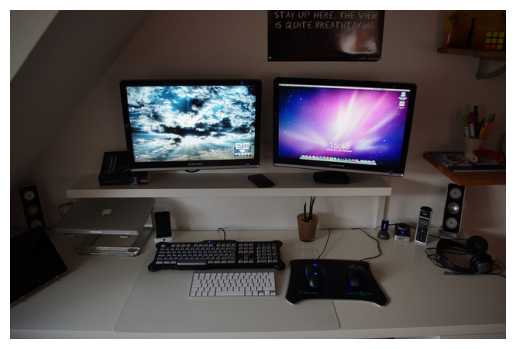

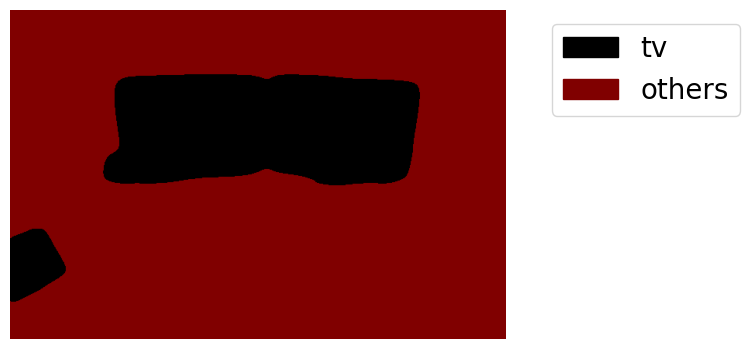

In [58]:
#LSEG Running
labels = []
print('** Input label value: {} **'.format(args.label_src))
lines = args.label_src.split(',')
for line in lines:
    label = line
    labels.append(label)
#labels.append("others")

#try:
#load image
#crop_size = 480
padding = [0.0] * 3
image = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
#plt.imshow(image)
image = np.array(image)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
image = transform(image).unsqueeze(0)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
#plt.imshow(img)


with torch.no_grad():
    outputs = evaluator.parallel_forward(image, labels) #evaluator.forward(image, labels) #parallel_forward
    #outputs = model(image,labels)
    predicts = [
        torch.max(output, 1)[1].cpu().numpy() 
        for output in outputs
    ]
#Lseg results    
predict = predicts[0]

new_palette = get_new_pallete(len(labels))
mask, patches = get_new_mask_pallete(predict, new_palette, out_label_flag=True, labels=labels)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
img = Image.fromarray(np.uint8(255*img)).convert("RGBA")
seg = mask.convert("RGBA")
out = Image.blend(img, seg, alpha)
plt.axis('off')
plt.imshow(img)
plt.figure()
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(seg)

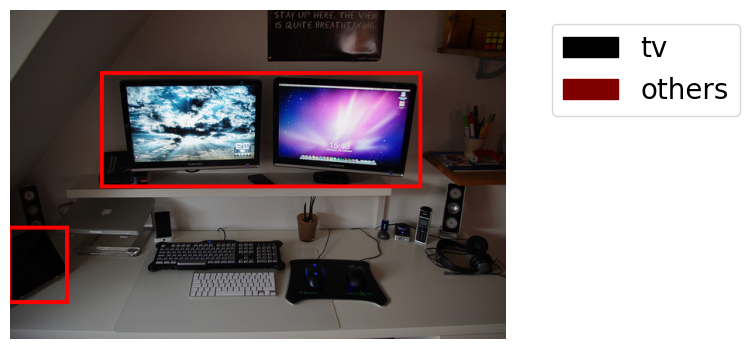

In [59]:
#get bbox
rgba_cols = palette_to_rgba(new_palette)
bboxes, segmaps = process_segmap(rgba_cols,seg)

#Show results of bounding boxes
from PIL import Image, ImageDraw
img_copy = img.copy()
#for i in range(0,len(bboxes)-1):
#    topLeft = (bboxes[i][0],bboxes[i][1])
#    bottomRight = (bboxes[i][2],bboxes[i][3])
#    img1 = ImageDraw.Draw(img_copy)
#    rect_color = getHexColor(rgba_cols[i])
#    draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=5)
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#plt.axis('off')
#plt.imshow(img_copy)

w,h = img.size
min_size = w*h*0.005 #arbitary min size, 0.005 for the cat human image
new_bbox = bbox_instancing(bboxes,segmaps,min_size=min_size) 

#sample bbox instancing result
img_copy_test = img.copy()
for i in range(len(new_bbox)-1):
    for j in range(len(new_bbox[i])):
        topLeft = (new_bbox[i][j][0],new_bbox[i][j][1])
        bottomRight = (new_bbox[i][j][2],new_bbox[i][j][3])
        img1 = ImageDraw.Draw(img_copy_test)
        #rect_color = getHexColor(rgba_cols[i])
        draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=5)
        #draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(img_copy_test)

In [60]:




img_copy_clip = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
img_copy_clip = np.array(img_copy_clip)
cropped_imgs = []
for class_bbox in new_bbox:
    cropped_imgs.append([])
    for bbox in class_bbox:
        cropped_imgs[len(cropped_imgs)-1].append(img_copy_clip[bbox[1]:bbox[3],bbox[0]:bbox[2]])



for cls in cropped_imgs:
    for i in range(len(cls)):
        #img_transform = transform(cls[i]).unsqueeze(0)
        #print(cls[i])
        cls[i]=Image.fromarray(cls[i])


vote_arr = [0]*len(new_bbox[0])

for sentence in ref['sentences']:          
    max_score = 0
    best_id = -1
    ret_index_temp = []
    ret_index_cls = []
    same_scores = 1
    #print("number of cropped: "+ str(len(cropped_imgs[0])))
    for j in range(len(cropped_imgs[0])): #for each cropped_image run it through clip with the label of description and get the highest scoring boxes
        #image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
        image = preprocess(cropped_imgs[0][j]).unsqueeze(0).to(device)
        #text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
        text = clip.tokenize([sentence['sent'], "other"]).to(device)  #extracted input is also based on class
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        print("Box "+str(j)+": "+str(probs[0][0]))
        #if score is higher than max, max = score and append to list. if score within 0.1 of max score, append as well
        if probs[0][0]>max_score:
            max_score = probs[0][0]
            best_id = j
        elif probs[0][0] == max_score:
            same_scores +=1
    if same_scores<len(cropped_imgs[0]):     
        vote_arr[best_id]+=max_score #avoid bias with the same score

#print(vote_arr)
best_bbox = vote_arr.index(max(vote_arr)) #narrow down 1 box in the instance first, then use region proposal within that box

Box 0: 0.945
Box 1: 0.991
Box 0: 0.1384
Box 1: 0.269
Box 0: 0.874
Box 1: 0.9688


In [61]:
vote_arr

[0, 2.22900390625]

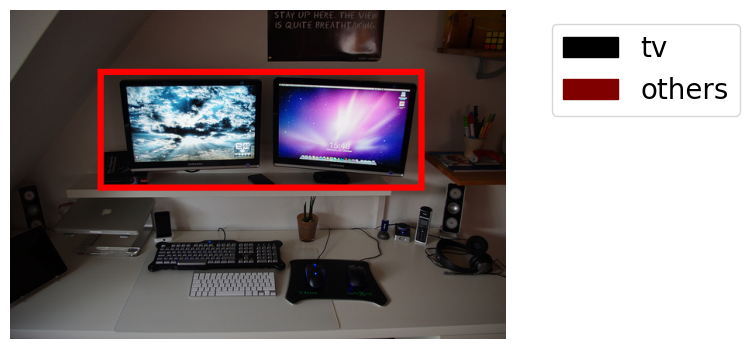

In [62]:
#draw results from clip
from PIL import Image, ImageDraw
img_copy_test2 = img.copy()
#print("clip retval: " + str(best_bbox))
#print((processed_new_bbox[i][j]))
topLeft = (new_bbox[0][best_bbox][0],new_bbox[0][best_bbox][1])
bottomRight = (new_bbox[0][best_bbox][2],new_bbox[0][best_bbox][3])
img2 = ImageDraw.Draw(img_copy_test2)
#rect_color = getHexColor(rgba_cols[i])
draw_rectangle(img2, (topLeft,bottomRight),color = "red", width=8)
new_bbox_xywh = [topLeft[0], topLeft[1], bottomRight[0]-topLeft[0], bottomRight[1]-topLeft[1]]
#ref_bbox = refer.refToAnn[ref_id]['bbox']
#IoU = computeIoU(ref_bbox, new_bbox_xywh)
#print("IoU:"+str(IoU))
#draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.axis('off')
plt.imshow(img_copy_test2)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})

In [63]:
#####REGION PROPOSAL########

prop_rects = ssearch(img_path+refer.loadImgs(image_id)[0]['file_name'], new_bbox[0][best_bbox], min_size) #uninstanced bboxes, use the best box and perform region proposal
img_copy_test = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
#print(prop_rects)
count = 0

best_bbox = -1

padding = [0.0] * 3
img_copy_clip = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
#print(type(img_copy_clip))
img_copy_clip = np.array(img_copy_clip)

cropped_imgs = [[]]


for bbox in prop_rects:
    #print(bbox)
    cropped_imgs[0].append(Image.fromarray(img_copy_clip[bbox[1]:bbox[3],bbox[0]:bbox[2]]))


vote_arr = []

best_id = -1


1360.0
Total Number of Region Proposals: 465


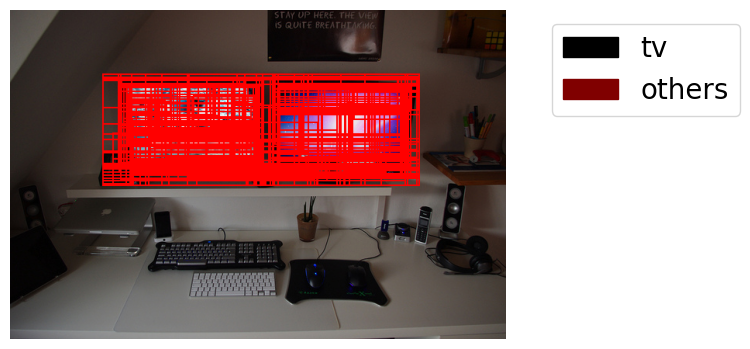

In [64]:

for rect in prop_rects:
    #print((processed_new_bbox[i][j]))
    topLeft = (rect[0],rect[1])
    bottomRight = (rect[2],rect[3])
    img1 = ImageDraw.Draw(img_copy_test)
    #rect_color = getHexColor(rgba_cols[i])
    #draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[0]), width=5)
    draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
    count+=1
    if count>1000:
        break
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#print("Input: "+user_input)
#bboxes

In [65]:
for sentence in ref['sentences']:          
    max_score = 0
    ret_index_temp = []
    ret_index_cls = []
    #print("number of cropped: "+ str(len(cropped_imgs[0])))
    for j in range(len(cropped_imgs[0])): #for each cropped_image run it through clip with the label of description and get the highest scoring boxes
        #print(j)
        #image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
        image = preprocess(cropped_imgs[0][j]).unsqueeze(0).to(device)
        #text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
        text = clip.tokenize([sentence['sent'], "other"]).to(device)  #extracted input is also based on class
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        print("Box "+str(j)+": "+str(probs[0][0]))
        #if score is higher than max, max = score and append to list. if score within 0.1 of max score, append as well
        if probs[0][0]>max_score:
            max_score = probs[0][0]
            best_id = j
    if best_id not in vote_arr:
        vote_arr.append(best_id)
    #else:
    #    break


Box 0: 0.9473
Box 1: 0.9697
Box 2: 0.4844
Box 3: 0.9927
Box 4: 0.986
Box 5: 0.7026
Box 6: 0.879
Box 7: 0.9863
Box 8: 0.6406
Box 9: 0.865
Box 10: 0.457
Box 11: 0.813
Box 12: 0.916
Box 13: 0.5
Box 14: 0.7026
Box 15: 0.9844
Box 16: 0.9985
Box 17: 0.9995
Box 18: 0.8154
Box 19: 0.983
Box 20: 0.4377
Box 21: 0.876
Box 22: 0.637
Box 23: 0.9663
Box 24: 0.9946
Box 25: 0.9956
Box 26: 0.831
Box 27: 0.8267
Box 28: 0.867
Box 29: 0.9995
Box 30: 0.9873
Box 31: 0.9727
Box 32: 0.9634
Box 33: 0.9795
Box 34: 0.874
Box 35: 0.8174
Box 36: 0.895
Box 37: 0.752
Box 38: 0.94
Box 39: 0.4417
Box 40: 0.994
Box 41: 0.9614
Box 42: 0.9976
Box 43: 0.987
Box 44: 0.982
Box 45: 0.9263
Box 46: 0.662
Box 47: 0.991
Box 48: 0.396
Box 49: 0.997
Box 50: 0.4456
Box 51: 0.996
Box 52: 0.9326
Box 53: 0.6187
Box 54: 0.951
Box 55: 0.8457
Box 56: 0.991
Box 57: 0.637
Box 58: 0.983
Box 59: 0.972
Box 60: 0.993
Box 61: 0.5312
Box 62: 0.9946
Box 63: 0.998
Box 64: 0.686
Box 65: 0.6655
Box 66: 0.966
Box 67: 0.9917
Box 68: 0.856
Box 69: 0.6


Box 79: 0.9336
Box 80: 0.9316
Box 81: 0.0914
Box 82: 0.1688
Box 83: 0.993
Box 84: 0.676
Box 85: 0.9956
Box 86: 0.1067
Box 87: 0.4805
Box 88: 0.989
Box 89: 0.1561
Box 90: 0.22
Box 91: 0.231
Box 92: 0.983
Box 93: 0.02518
Box 94: 0.01799
Box 95: 0.9355
Box 96: 0.0336
Box 97: 0.1144
Box 98: 0.04535
Box 99: 0.3774
Box 100: 0.248
Box 101: 0.1481
Box 102: 0.291
Box 103: 0.01049
Box 104: 0.989
Box 105: 0.9946
Box 106: 0.9443
Box 107: 0.212
Box 108: 0.2095
Box 109: 0.0792
Box 110: 0.3345
Box 111: 0.3774
Box 112: 0.1779
Box 113: 0.984
Box 114: 0.9946
Box 115: 0.2173
Box 116: 0.291
Box 117: 0.997
Box 118: 0.772
Box 119: 0.9863
Box 120: 0.3174
Box 121: 0.1294
Box 122: 0.7056
Box 123: 0.396
Box 124: 0.1755
Box 125: 0.961
Box 126: 0.2227
Box 127: 0.2281
Box 128: 0.269
Box 129: 0.963
Box 130: 0.858
Box 131: 0.74
Box 132: 0.1896
Box 133: 0.3174
Box 134: 0.04337
Box 135: 0.655
Box 136: 0.9546
Box 137: 0.0695
Box 138: 0.1993
Box 139: 0.1666
Box 140: 0.1192
Box 141: 0.9834
Box 142: 0.37
Box 143: 0.947
Bo

Box 143: 0.9653
Box 144: 0.4111
Box 145: 0.7217
Box 146: 0.1404
Box 147: 0.3557
Box 148: 1.0
Box 149: 0.9995
Box 150: 0.2018
Box 151: 0.824
Box 152: 0.2095
Box 153: 1.0
Box 154: 0.2451
Box 155: 0.997
Box 156: 0.999
Box 157: 0.0379
Box 158: 0.991
Box 159: 0.589
Box 160: 0.9995
Box 161: 0.4417
Box 162: 0.769
Box 163: 0.725
Box 164: 0.5547
Box 165: 0.08386
Box 166: 0.5156
Box 167: 0.269
Box 168: 0.8823
Box 169: 0.8057
Box 170: 0.9985
Box 171: 0.9995
Box 172: 0.508
Box 173: 0.829
Box 174: 0.0914
Box 175: 0.772
Box 176: 0.615
Box 177: 0.2173
Box 178: 0.955
Box 179: 0.9946
Box 180: 0.989
Box 181: 0.2394
Box 182: 1.0
Box 183: 0.4072
Box 184: 0.995
Box 185: 0.9727
Box 186: 0.8774
Box 187: 0.994
Box 188: 0.434
Box 189: 0.7637
Box 190: 0.562
Box 191: 0.7188
Box 192: 0.02635
Box 193: 0.10376
Box 194: 0.4263
Box 195: 0.15
Box 196: 0.996
Box 197: 0.15
Box 198: 0.4922
Box 199: 0.9897
Box 200: 0.2281
Box 201: 0.5776
Box 202: 0.9927
Box 203: 0.4688
Box 204: 0.9365
Box 205: 0.3381
Box 206: 0.946
Box 20

In [66]:
vote_arr
#best_id = 585

[231, 153, 7]

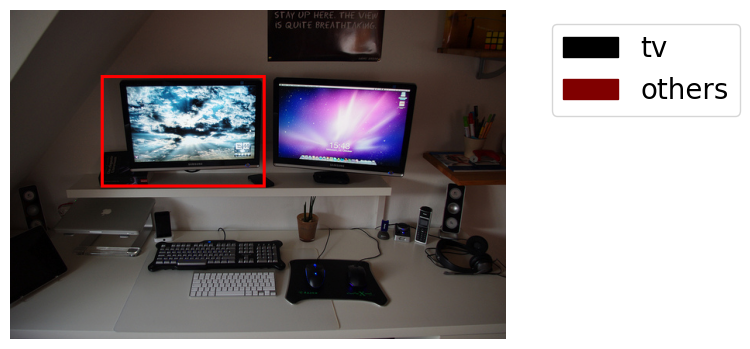

In [67]:
from PIL import Image, ImageDraw
img_copy_test = img.copy()

#idx = best_id
#print((processed_new_bbox[i][j]))
topLeft_new = [99999999,9999999]
botRight_new = [-1,-1]

for box_id in vote_arr:
    #print(prop_rects[box_id])
    if prop_rects[box_id][0]<topLeft_new[0]:
        topLeft_new[0] = prop_rects[box_id][0]
    if prop_rects[box_id][1]<topLeft_new[1]:
        topLeft_new[1] = prop_rects[box_id][1]
    if prop_rects[box_id][2]>botRight_new[0]:
        botRight_new[0] = prop_rects[box_id][2]
    if prop_rects[box_id][3]>botRight_new[1]:
        botRight_new[1] = prop_rects[box_id][3]
final_bbox = [topLeft_new[0], topLeft_new[1], botRight_new[0],botRight_new[1]]
final_bbox
img2 = ImageDraw.Draw(img_copy_test)
#rect_color = getHexColor(rgba_cols[i])
#draw_rectangle(img2, (topLeft_new,botRight_new),color = tuple(rgba_cols[i]), width=4)
draw_rectangle(img2, (topLeft_new,botRight_new),color = "red", width=4)
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#**TODO** IOU, remember to check for size difference
#plt.figure()
#refer.showRef(ref, seg_box='box')
#plt.show()

1. monitor with scene not screensaver
2. clouds
3. screen with clouds


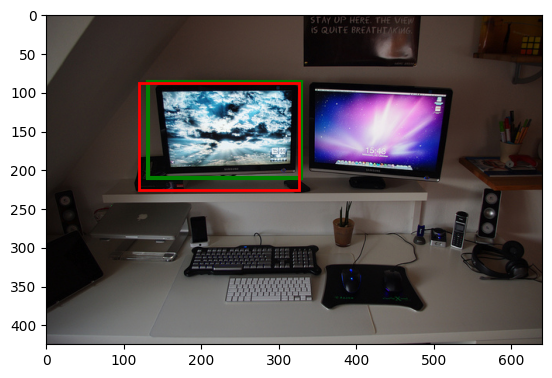

In [68]:
plt.figure()
refer.showRef(ref, seg_box='box')
ax = plt.gca()
box_plot = Rectangle((topLeft_new[0], topLeft_new[1]), botRight_new[0]-topLeft_new[0], botRight_new[1]-topLeft_new[1], fill=False, edgecolor='red', linewidth=2)
ax.add_patch(box_plot)
plt.show()

In [69]:
new_bbox_xywh = [topLeft_new[0], topLeft_new[1], botRight_new[0]-topLeft_new[0], botRight_new[1]-topLeft_new[1]]
ref_bbox = refer.refToAnn[ref_id]['bbox']
IoU = computeIoU(ref_bbox, new_bbox_xywh)
IoU

0.8143351492856321

<h2>Bounding Box verification depending on the vote arr (Debug)</h2>

In [18]:
j = 143
image = preprocess(cropped_imgs[0][j]).unsqueeze(0).to(device)
#text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
text = clip.tokenize([sentence['sent'], "other"]).to(device)  #extracted input is also based on class
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

#print("Box "+str(j)+": "+str(probs[0][0]))
probs

array([[1.00e+00, 1.55e-06]], dtype=float16)

In [19]:
topLeft_new = [99999999,9999999]
botRight_new = [-1,-1]

box_id = j
#print(prop_rects[box_id])
if prop_rects[box_id][0]<topLeft_new[0]:
    topLeft_new[0] = prop_rects[box_id][0]
if prop_rects[box_id][1]<topLeft_new[1]:
    topLeft_new[1] = prop_rects[box_id][1]
if prop_rects[box_id][2]>botRight_new[0]:
    botRight_new[0] = prop_rects[box_id][2]
if prop_rects[box_id][3]>botRight_new[1]:
    botRight_new[1] = prop_rects[box_id][3]
final_bbox = [topLeft_new[0], topLeft_new[1], botRight_new[0],botRight_new[1]]
final_bbox

[462, 207, 544, 314]

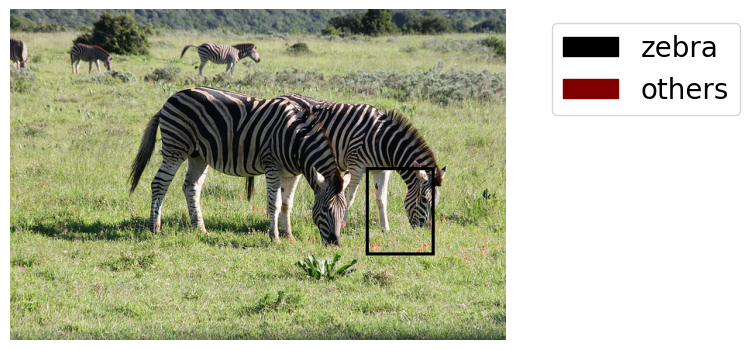

In [20]:
from PIL import Image, ImageDraw
img_copy_test = img.copy()

idx = best_id
#print((processed_new_bbox[i][j]))
#topLeft = (prop_rects[idx][0],prop_rects[idx][1])
#bottomRight = (prop_rects[idx][2],prop_rects[idx][3])
img2 = ImageDraw.Draw(img_copy_test)
#rect_color = getHexColor(rgba_cols[i])
draw_rectangle(img2, (topLeft_new,botRight_new),color = tuple(rgba_cols[i]), width=4)
#draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#**TODO** IOU, remember to check for size difference
#plt.figure()
#refer.showRef(ref, seg_box='box')
#plt.show()

In [21]:
new_bbox_xywh = [topLeft_new[0], topLeft_new[1], botRight_new[0]-topLeft_new[0], botRight_new[1]-topLeft_new[1]]
ref_bbox = refer.refToAnn[ref_id]['bbox']
IoU = computeIoU(ref_bbox, new_bbox_xywh)
IoU

0.16541986980386134